<a href="https://colab.research.google.com/github/jmvillarreal99/Data-Science-and-Decision-Making/blob/main/labs/lab4/Causal_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Lab**

In [ ]:
!pip install econml

In [ ]:
!wget https://github.com/dmachlanski/CE888_2022/raw/main/lab4/data/sodium_10k.npz

In [2]:
from econml.metalearners import XLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Code**

Metrics

In [11]:
def abs_ate(effect_true, effect_pred):
  ATE=np.abs(np.mean(effect_true)-np.mean(effect_pred))
  return ATE
def pehe(effect_true, effect_pred):
  PEHE=np.sqrt(np.mean((np.subtract(effect_true, effect_pred))**2))
  return PEHE

Data

In [4]:
data = np.load('sodium_10k.npz')

Reshape

In [7]:
X = data['x'].reshape(-1, 1)
T = data['t'].reshape(-1, 1)
Y = data['y'].reshape(-1, 1)
ite = data['ite']

Plot distributions

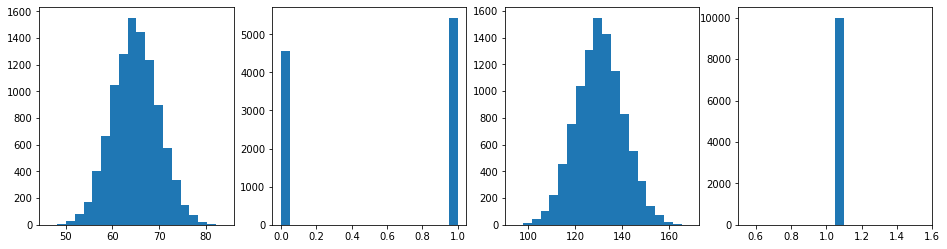

In [8]:
bins=20
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].hist(X, bins=bins)
axs[1].hist(T, bins=bins)
axs[2].hist(Y, bins=bins)
axs[3].hist(ite, bins=bins)
plt.show()

Scatter Plots

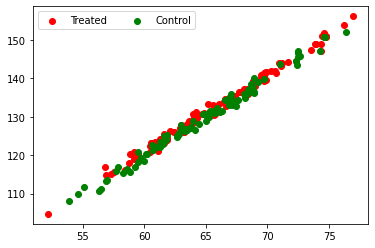

In [9]:
limit = 100
plt.scatter(X[T == 1][:limit], Y[T == 1][:limit], c = "r", label = "Treated")
plt.scatter(X[T == 0][:limit], Y[T == 0][:limit], c = "g", label = "Control")
plt.legend(ncol=2)

**Preprocessing**

Split the data

In [10]:
x_train, x_test, t_train, t_test, y_train, y_test, ite_train, ite_test = train_test_split(X, T, Y, ite, test_size=0.2)

scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)

**Training**

*Random Forest*

In [13]:
# Random Forest with default parameters.
rf = RandomForestRegressor()

# Train on the training data.
# In the supervised setting, our usual X here consists of X and T.
# The target is Y - the outcome.
# Input: [X, T], output: Y.
# Hint: use np.concatenate or np.hstack functions to merge X and T.

xt_train = np.concatenate([x_train,t_train], axis=1)
rf.fit(xt_train, y_train.flatten())

# Predictions
# Note we set T to a specific value for ALL individuals.
# These are interventional distributions - P(Y|X, do(T=t)).

# Predict Y_0 given [X, 0]
# Hint: use np.zeros_like or np.zeros functions to get the zeros for all units.
# Hint 2: you still have to merge X and zeros (see training above).
xt0_test = np.concatenate([x_test,np.zeros_like(t_test)], axis=1)
rf_y0_test = rf.predict(xt0_test)

# Predict Y_1 given [X, 1]
# Hint: use np.ones_like or np.ones functions to get the ones for all units.
# Hint 2: you still have to merge X and ones (see training above).
xt1_test = np.concatenate([x_test,np.ones_like(t_test)], axis=1)
rf_y1_test = rf.predict(xt1_test)

# Compute ITEs
# ITE = Y_1 - Y_0
rf_te_test = np.subtract(rf_y1_test, rf_y0_test)

*Random Forest with IPW*

In [14]:
def get_ps_weights(clf, x, t):
  ti = np.squeeze(t)
  clf.fit(x, ti)
  ptx = clf.predict_proba(x).T[1].T + 0.0001 # add a small value to avoid dividing by 0
  # Given ti and ptx values, compute the weights wi (see formula above):
  wi = (ti/ptx)+((1-ti)/(1-ptx))
  return wi

In [17]:
# Get the sample weights
prop_clf = RandomForestClassifier()
weights = get_ps_weights(prop_clf, x_train, t_train)

# Train the regressor
rf_ipsw = RandomForestRegressor()

rf_ipsw.fit(np.concatenate([x_train,t_train], axis=1), y_train.flatten(), sample_weight=weights)

# Make predictions
rf_ipsw_y0_test = rf.predict(np.concatenate([x_test,np.zeros_like(t_test)], axis=1))
rf_ipsw_y1_test = rf.predict(np.concatenate([x_test,np.ones_like(t_test)], axis=1))

# Compute ITEs
rf_ipsw_te_test = np.subtract(rf_ipsw_y1_test, rf_ipsw_y0_test)

*X-Learner*

In [18]:
xl = XLearner(models=RandomForestRegressor(), propensity_model=RandomForestClassifier())
xl.fit(y_train, t_train.flatten(), X=x_train)

xl_te_test = xl.effect(x_test)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


**Evaluation**

*Metrics*

In [19]:
# Error on ATE
# Use our 'abs_ate' function, true ITEs and predicted ITEs to get the measurements.
rf_ate_test = abs_ate(ite_test, rf_te_test)
rf_ipsw_ate_test = abs_ate(ite_test, rf_ipsw_te_test)
xl_ate_test = abs_ate(ite_test, xl_te_test)

# PEHE
# Use our 'pehe' function, true ITEs and predicted ITEs to get the measurements.
rf_pehe_test = pehe(ite_test, rf_te_test)
rf_ipsw_pehe_test = pehe(ite_test, rf_ipsw_te_test)
xl_pehe_test = pehe(ite_test, xl_te_test)

In [20]:
results = []
results.append(['RF', rf_ate_test, rf_pehe_test])
results.append(['RF (IPW)', rf_ipsw_ate_test, rf_ipsw_pehe_test])
results.append(['XL', xl_ate_test, xl_pehe_test])

cols = ['Method', 'ATE test', 'PEHE test']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATE test,PEHE test
0,RF,0.021297,0.955221
1,RF (IPW),0.021297,0.955221
2,XL,0.027469,0.865155


*Confidence intervals*

In [21]:
def mean_ci(data, ci=0.95):
  l_mean = np.mean(data)
  lower, upper = st.t.interval(ci, len(data)-1, loc=l_mean, scale=st.sem(data))
  return l_mean, lower, upper

In [22]:
rf_ate_bounds = mean_ci(rf_te_test)
rf_ipsw_ate_bounds = mean_ci(rf_ipsw_te_test)
xl_ate_bounds = mean_ci(xl_te_test)

results = []
results.append(['RF', rf_ate_bounds[0], rf_ate_bounds[1], rf_ate_bounds[2]])
results.append(['RF (IPW)', rf_ipsw_ate_bounds[0], rf_ipsw_ate_bounds[1], rf_ipsw_ate_bounds[2]])
results.append(['XL', xl_ate_bounds[0], xl_ate_bounds[1], xl_ate_bounds[2]])

cols = ['Method', 'ATE mean', 'CI lower', 'CI upper']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATE mean,CI lower,CI upper
0,RF,1.071297,1.029408,1.113186
1,RF (IPW),1.071297,1.029408,1.113186
2,XL,1.077469,[1.039539649486344],[1.1153991024112997]


Visualisations

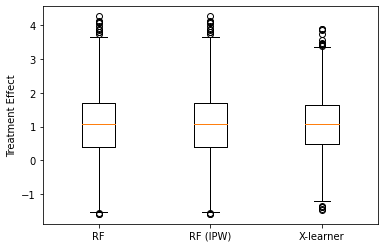

In [23]:
plt.figure()
plt.boxplot([rf_te_test, rf_ipsw_te_test, xl_te_test.flatten()], labels=['RF', 'RF (IPW)', 'X-learner'])
plt.ylabel('Treatment Effect')

plt.show()

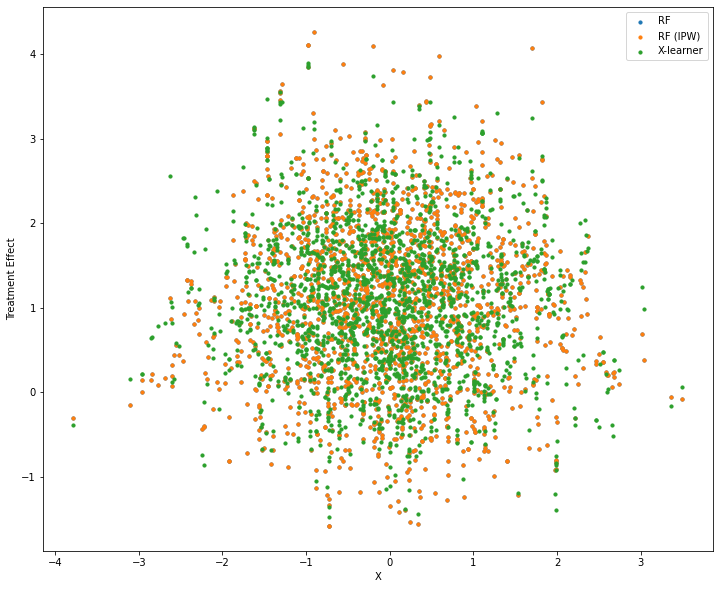

In [24]:
plt.figure(figsize=(12, 10))
m_size = 10
plt.scatter(x_test, rf_te_test, label="RF", s=m_size)
plt.scatter(x_test, rf_ipsw_te_test, label="RF (IPW)", s=m_size)
plt.scatter(x_test, xl_te_test, label="X-learner", s=m_size)
plt.xlabel('X')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()